# Import Libs

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



# 0. Preparation (Setting the Random State)

In [4]:
rs = min(289456, 274211)
np.random.seed(rs)

# Exercise 1 (Loading and Preparing the Data)
craeting sub_DF `workdf` and removing some random columns and updating

In [5]:
# 1.1 Load the CSV file into a pandas DataFrame
df_tot = pd.read_csv('cla4lsp_customers.csv', sep='\t')

# 1.2 Create a sub-DF workdf with 2/3 of the original dataframe's rows (randomly sampled)
workdf = df_tot.sample(frac=2 / 3, random_state=rs)
# 1.3 hard-code labels and feature
labels = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
          'AcceptedCmp5', 'Response', 'Complain', 'Recency']
features = ['Education', 'Marital_Status', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
            'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
columns_to_remove = ['ID', 'Z_CostContact', 'Z_Revenue']
# 1.4 Remove one feature column randomly from spending or purchasing habits
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                    'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
                    'NumCatalogPurchases', 'NumStorePurchases']
col_to_remove = np.random.choice(spending_columns)
columns_to_remove.append(col_to_remove)
print("Random Column to be dropped: ", col_to_remove)
features.remove(col_to_remove)
workdf.drop(columns_to_remove, axis=1, inplace=True)
workdf.info() #for checking the object type of the columns

Random Column to be dropped:  MntSweetProducts
<class 'pandas.core.frame.DataFrame'>
Index: 1493 entries, 335 to 1224
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           1493 non-null   int64  
 1   Education            1493 non-null   object 
 2   Marital_Status       1493 non-null   object 
 3   Income               1476 non-null   float64
 4   Kidhome              1493 non-null   int64  
 5   Teenhome             1493 non-null   int64  
 6   Dt_Customer          1493 non-null   object 
 7   Recency              1493 non-null   int64  
 8   MntWines             1493 non-null   int64  
 9   MntFruits            1493 non-null   int64  
 10  MntMeatProducts      1493 non-null   int64  
 11  MntFishProducts      1493 non-null   int64  
 12  MntGoldProds         1493 non-null   int64  
 13  NumDealsPurchases    1493 non-null   int64  
 14  NumWebPurchases      1493 non-null   int64  

In [6]:
workdf.isnull().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 17
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64

    Since we have missing values in the income column we drop the missing values

In [7]:
# 1.5 Clean the dataset from missing values in the feature columns
workdf.dropna(inplace=True)
workdf.isnull().sum()


Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
dtype: int64

# Exercise 2 (Encoding of Categorical Data)

In [8]:
categorical_columns = list(workdf.select_dtypes(include=['object']).columns)
categorical_columns

['Education', 'Marital_Status', 'Dt_Customer']

In [9]:
for col in categorical_columns:
    unique_values = workdf[col].unique()
    print(f"Number of Unique values in '{col}': {len(unique_values)}")
    if len(unique_values) < 20:
        print(unique_values)


Number of Unique values in 'Education': 5
['Graduation' 'Master' 'PhD' '2n Cycle' 'Basic']
Number of Unique values in 'Marital_Status': 8
['Divorced' 'Together' 'Married' 'Single' 'Widow' 'Alone' 'YOLO' 'Absurd']
Number of Unique values in 'Dt_Customer': 609


1. Education:
Suggested Encoding Method: Ordinal Encoding or One-Hot Encoding
 - Reasoning:
If there is an inherent order in the education levels (e.g., "High School" < "Bachelor" < "Master"), you might consider using Ordinal Encoding.
If there is no specific order, and each education level is independent, One-Hot Encoding is often preferred.
2. Marital_Status:
Suggested Encoding Method: One-Hot Encoding
- Reasoning:
Marital status typically doesn't have a natural order, making One-Hot Encoding a suitable choice.
3. Dt_Customer:
Suggested Encoding Method: Ordinal Encoding (if there's an order) or Feature Engineering
Since this column represents dates, encoding methods are a bit different compared to traditional categorical variables. Instead of directly encoding the date, we'll extract useful features from it. Common features to extract include the year, month, day, and potentially others like day of the week.


## Encoding for Dt_Customer:

In [10]:
Xworkdf = workdf[features].copy()
Xworkdf['Dt_Customer'] = pd.to_datetime(Xworkdf['Dt_Customer'], format="%d-%m-%Y")
Xworkdf['Dt_Customer_Year'] = Xworkdf['Dt_Customer'].dt.year
Xworkdf['Dt_Customer_Month'] = Xworkdf['Dt_Customer'].dt.month
Xworkdf['Dt_Customer_Day'] = Xworkdf['Dt_Customer'].dt.day
Xworkdf['Dt_Customer_DayOfWeek'] = Xworkdf['Dt_Customer'].dt.dayofweek

# now that we're done we can drop Dt_Customer
Xworkdf.drop("Dt_Customer", axis=1, inplace=True)
Xworkdf.columns

Index(['Education', 'Marital_Status', 'Year_Birth', 'Income', 'Kidhome',
       'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntGoldProds', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Dt_Customer_Year', 'Dt_Customer_Month', 'Dt_Customer_Day',
       'Dt_Customer_DayOfWeek'],
      dtype='object')

In [11]:
categorical_columns = [ 'Marital_Status']

Xworkdf = pd.get_dummies(Xworkdf, columns=categorical_columns)

#encode the education column as ordinal
education_map = {'Basic': 0, '2n Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
Xworkdf['Education'] = Xworkdf['Education'].map(education_map)

features = Xworkdf.columns



In [12]:
Xworkdf.head()

,Education,Year_Birth,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntGoldProds,...,Dt_Customer_Day,Dt_Customer_DayOfWeek,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
335,2,1960,62204.0,0,2,317,46,247,151,139,...,12,2,False,False,True,False,False,False,False,False
798,2,1973,73926.0,0,0,627,91,597,159,15,...,2,5,False,False,False,False,False,True,False,False
1707,2,1965,52117.0,0,1,112,10,107,30,20,...,16,3,False,False,False,False,False,True,False,False
999,2,1956,46086.0,0,1,244,8,32,7,50,...,3,6,False,False,True,False,False,False,False,False
1947,3,1974,83891.0,0,1,217,38,350,111,15,...,20,4,False,False,False,True,False,False,False,False


In [13]:
Xworkdf.columns


Index(['Education', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntGoldProds',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Dt_Customer_Year', 'Dt_Customer_Month',
       'Dt_Customer_Day', 'Dt_Customer_DayOfWeek', 'Marital_Status_Absurd',
       'Marital_Status_Alone', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow',
       'Marital_Status_YOLO'],
      dtype='object')

# Exercise 3 (Preprocessing and full-PCA)

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# create a DataFrame with the standardized features
Xworkdf_std = pd.DataFrame(std_scaler.fit_transform(Xworkdf))
Xworkdf_mm = pd.DataFrame(minmax_scaler.fit_transform(Xworkdf))

# Assign column names to the standardized DataFrame
Xworkdf_std.columns = Xworkdf.columns

# Assign column names to the min-max scaled DataFrame
Xworkdf_mm.columns = Xworkdf.columns

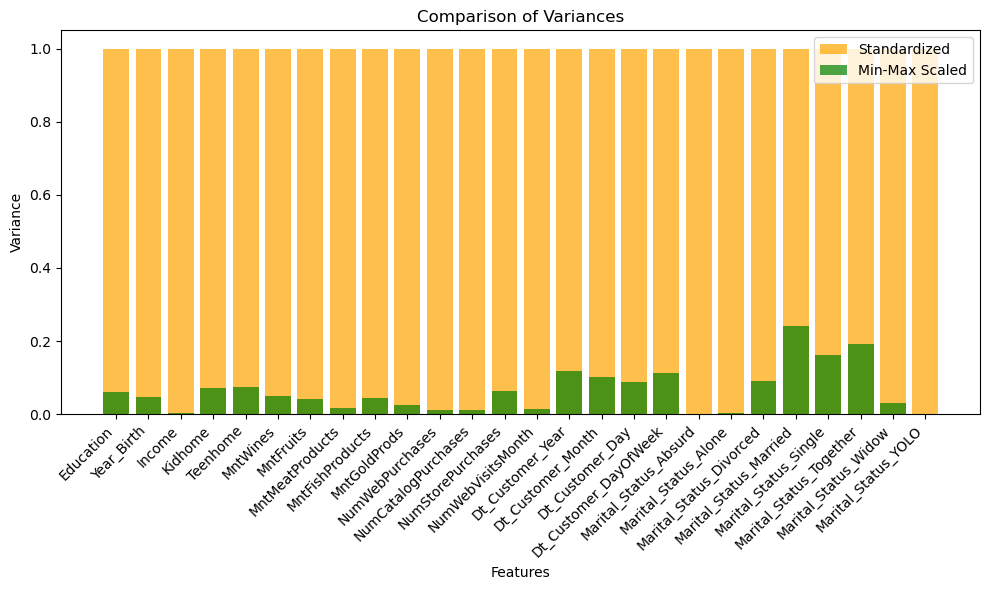

In [19]:

# Calculate variances for each DataFrame
variances_original = Xworkdf.var()
variances_std = Xworkdf_std.var()
variances_mm = Xworkdf_mm.var()

# Plot the variances
plt.figure(figsize=(10, 6))
plt.bar(variances_std.index, variances_std, color='orange', alpha=0.7, label='Standardized')
plt.bar(variances_mm.index, variances_mm, color='green', alpha=0.7, label='Min-Max Scaled')

plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Comparison of Variances')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [ ]:
variance_comparison = pd.DataFrame({
    'Original': variances_original,
    'StandardScaler': variances_std,
    'MinMaxScaler': variances_mm
})

# Display the comparison
print(variance_comparison)


### Analyzing the Variance of across dataframes
01. Original Data:
The variances in the `"Original"` column represent the original distribution of the data before any scaling.
Variances vary significantly across columns, as the scale of the features is different.

2. MinMaxScaler (scaling values to a specific range, e.g., `[0, 1]`)
The variance is generally affected. Min-Max Scaling squeezes the data within a fixed interval(in this case `[0,1]`), so the range of values will be smaller, impacting the spread of the data.

3. Standardscaler (Z-score Normalization):
Standardscaler centers the data around a mean of `0` and scales it by the standard deviation. This process does not change the variance, as it maintains the spread of the data relative to its mean.

## Apply the “full” PCA

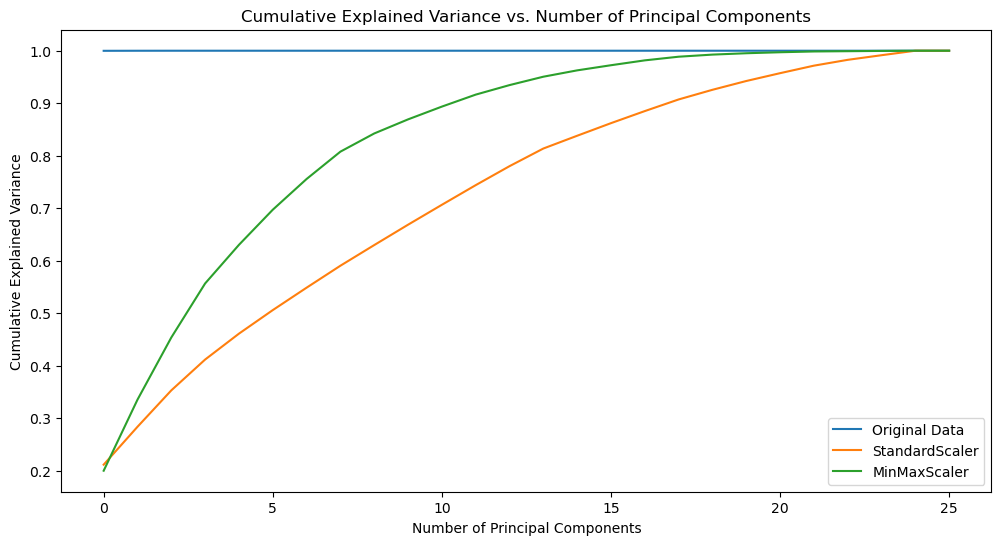

In [21]:
from sklearn.decomposition import PCA

# Initialize PCA for each dataframe
pca_original = PCA()
pca_std = PCA()
pca_mm = PCA()

# Fit and transform the data
_ = pca_original.fit_transform(Xworkdf)
_ = pca_std.fit_transform(Xworkdf_std)
_ = pca_mm.fit_transform(Xworkdf_mm)

# Calculate cumulative explained variance
cumulative_explained_variance_original = np.cumsum(pca_original.explained_variance_ratio_)
cumulative_explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
cumulative_explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_explained_variance_original, label='Original Data')
plt.plot(cumulative_explained_variance_std, label='StandardScaler')
plt.plot(cumulative_explained_variance_mm, label='MinMaxScaler')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()



- The blue curve represents the PCA on the `original` dataset. `It rises quickly`, which suggests that the first few principal components explain a significant amount of variance. so strong patterns or correlations that PCA can capture early on

- Usuing standard scaler usaully gives better results than minmax scaler becuase features have different scales and units,This is why the cumulative explained variance might rise quicker for PCA on standardized data as we can see at the very first components of PCA.

- However, the cumulative explained variance for PCA on min-max scaled data rises quicker towards the end of the plot.the late rise in cumulative variance for MinMax scaled data could be a sign that the features contributing most to the variance are better represented in the later components when using this scaling method.

- StandardScaler standardizes features by removing the mean and scaling to unit variance. In other words, it centers the data around zero with a
standard deviation of one. This is particularly useful when different features have different units or scales.

- MinMaxScalertransforms features by scaling each feature to a given range, typically [0, 1]. It preserves the shape of the dataset's distribution but not the mean and variance.

# Exercise 4 (Dimensionality Reduction and Interpretation of the PCs)

Number of PCs for StandardScaler: 3
Number of PCs for MinMaxScaler: 2


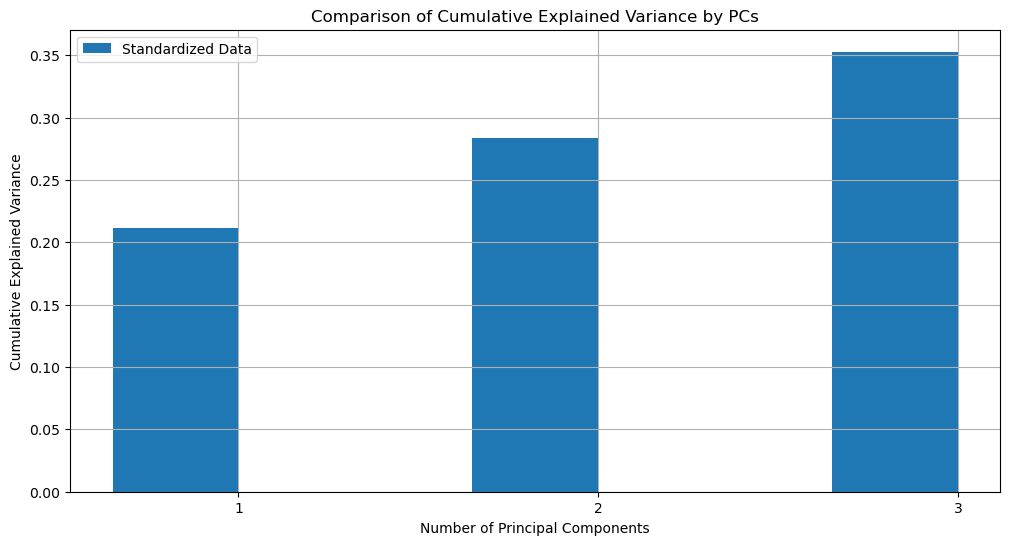

array([0.21122128, 0.28342008, 0.3528072 ])

In [36]:
variance_threshold = 0.33
num_pcs_std = np.argmax(cumulative_explained_variance_std >= variance_threshold) + 1
num_pcs_mm = np.argmax(cumulative_explained_variance_mm >= variance_threshold) + 1

m_std = min(num_pcs_std, 5)
m_mm = min(num_pcs_mm, 5)
print(f"Number of PCs for StandardScaler: {m_std}")
print(f"Number of PCs for MinMaxScaler: {m_mm}")

pca_std = PCA(n_components=m_std)
pca_mm = PCA(n_components=m_mm)

X_std_pca = pca_std.fit_transform(Xworkdf_std)
X_mm_pca = pca_mm.fit_transform(Xworkdf_mm)

cumulative_explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)
cumulative_explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

# AS menthoned before, usuing standard scaler usaully gives better results than minmax scaler becuase for firsts principal components,
# This is why the cumulative explained variance might rise quicker for PCA.

# Plot the cumulative explained variance
# Assuming cumulative_explained_variance_std and cumulative_explained_variance_mm are already computed
num_pcs = max(len(cumulative_explained_variance_std), len(cumulative_explained_variance_mm))
indices = np.arange(1, num_pcs + 1)

# Set the bar width
bar_width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bar1 = plt.bar(indices - bar_width / 2, cumulative_explained_variance_std[:num_pcs], bar_width, label='Standardized Data')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Comparison of Cumulative Explained Variance by PCs')
plt.xticks(indices)
plt.legend()
plt.grid(True)
plt.show()
cumulative_explained_variance_std

## Extract Dominant Features and Create a Summary Table

In [58]:
def get_dominant_features(pca, feature_names, num_top_features=10):
    """
    Function to identify dominant features for each principal component.
    :param pca: Fitted PCA object
    :param feature_names: List of original feature names
    :param num_top_features: Number of top features to list for each component
    :return: DataFrame with dominant features for each PC
    """
    components = pca.components_
    dominant_features = []

    for i, pc in enumerate(components):
        component_loadings = zip(feature_names, pc)
        sorted_features = sorted(component_loadings, key=lambda x: abs(x[1]), reverse=True)
        top_features = sorted_features[:num_top_features]
        dominant_features.append([f"{feature[0]} ({feature[1]:.2f})" for feature in top_features])

    return pd.DataFrame(dominant_features, index=[f'PC{i + 1}' for i in range(len(components))])


def create_summary_table(pca, dominant_features):
    """
    Function to create a summary table for PCA results.
    :param pca: Fitted PCA object
    :param dominant_features: DataFrame with dominant features for each PC
    :return: Summary DataFrame
    """
    explained_variance = [f"{var:.2%}" for var in pca.explained_variance_ratio_]
    summary_df = pd.DataFrame({
        'Principal Component': dominant_features.index,
        'Explained Variance': explained_variance,
        'Dominant Features': dominant_features.values.tolist()
    })
    return summary_df

In [59]:
dominant_features_std = get_dominant_features(pca_std, features)
dominant_features_mm = get_dominant_features(pca_mm, features)

summary_table_std = create_summary_table(pca_std, dominant_features_std)
summary_table_mm = create_summary_table(pca_mm, dominant_features_mm)

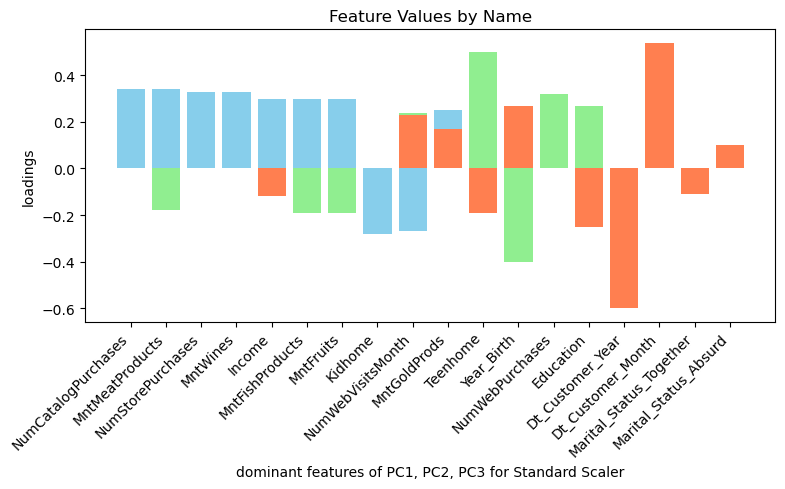

In [87]:
name1 = dominant_features_std.iloc[0,].str.extract(r'^(.*) \(')[0]
values1 = dominant_features_std.iloc[0,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name2 = dominant_features_std.iloc[1,].str.extract(r'^(.*) \(')[0]
values2 = dominant_features_std.iloc[1,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)
name3 = dominant_features_std.iloc[2,].str.extract(r'^(.*) \(')[0]
values3 = dominant_features_std.iloc[2,].str.extract(r'\(([-0-9.]+)\)')[0].astype(float)


plt.figure(figsize=(8, 5))
bars = plt.bar(name1, values1, color='skyblue') 
bars = plt.bar(name2, values2, color='lightgreen') 
bars = plt.bar(name3, values3, color='coral') 

plt.xlabel('dominant features of PC1, PC2, PC3 for Standard Scaler')
plt.ylabel('loadings')
plt.xticks(rotation=45, ha="right")
plt.title('Feature Values by Name')
plt.tight_layout()



## Interpretation 
To be able to interpret the obtained principal components, we first need to find the high value positive and negative loadings of each principal component.

To find the high values loads of a principle component, we have to take the following steps: 
- After fitting the PCA model, access the components_ attribute of the model to get the loadings of the principal components. For example pca.components_[0] gives the loadings of the first principal component. What we get is an array of loadings for each column (Either positive or negative).
- Then for obtaining the high value loadings, considering the absolute value of the loadings, we sort the array of loadings in descending order and take the first 𝑛 elements`here we consider n=10` of the array. The indices of these elements are the indices of the columns that have the high value loadings for the corresponding principal component.

1. As could be seen in the above graphs, for PC1, the most important high values are `NumCategoricalPurchases`, `MntMeatProducts`, `NumStorePurchases`so we can name them as **purchases Group** 
2. For PC2 important features are `teenhome`, `year_Birth`, `NumWebPurchases`, `Dt_customer_year` we labeled them as **teenS Web Purchases**
3. For the PC3 `Dt_customer_year`, `Dt_customer_Month`, `year_Birth` have high loading and they are labeled as **Date of customer’s enrollment**

In [41]:
summary_table_mm

,Principal Component,Explained Variance,Dominant Features
0,PC1,19.97%,"[Marital_Status_Married (0.82), Marital_Status..."
1,PC2,13.54%,"[Marital_Status_Single (0.74), Marital_Status_..."


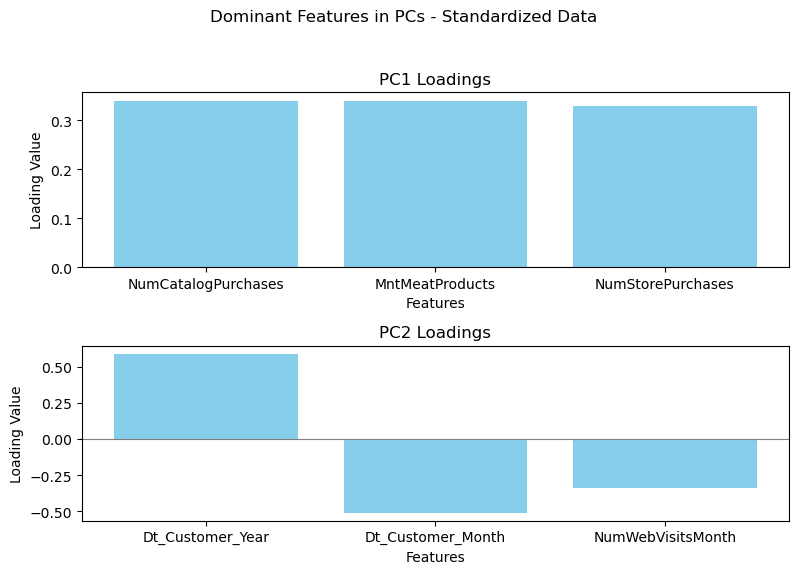

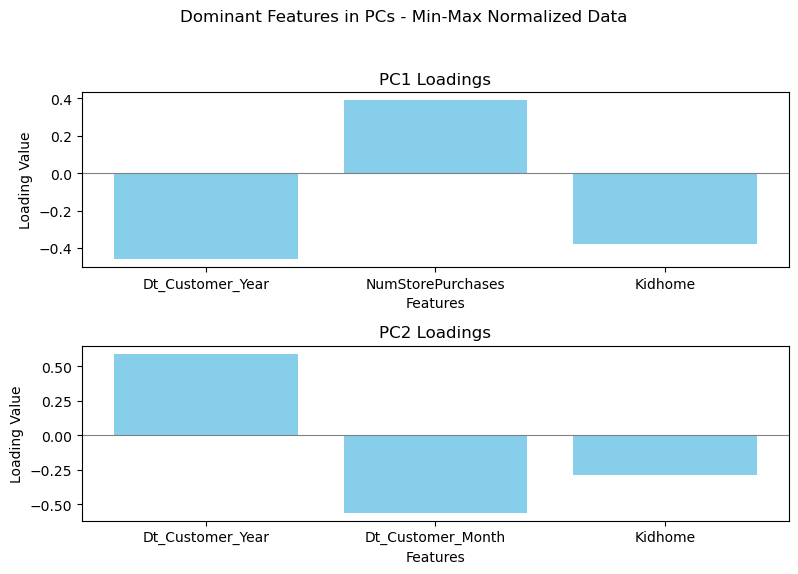

In [45]:
def plot_dominant_features(dominant_features, title):
    """
    Plot the dominant features and their loadings for each principal component.
    :param dominant_features: DataFrame with dominant features and their loadings
    :param title: Title for the plot
    """
    fig, axes = plt.subplots(nrows=len(dominant_features), ncols=1, figsize=(8, len(dominant_features) * 3))

    if len(dominant_features) == 1:
        axes = [axes]  # Ensure axes is always a list

    for i, pc in enumerate(dominant_features.index):
        pc_data = dominant_features.loc[pc]
        labels, loadings = zip(*[feature.split(' (') for feature in pc_data])
        loadings = [float(loading.replace(')', '')) for loading in loadings]

        axes[i].bar(labels, loadings, color='skyblue')
        axes[i].set_title(f'{pc} Loadings')
        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Loading Value')
        axes[i].axhline(0, color='gray', linewidth=0.8)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Example usage
plot_dominant_features(dominant_features_std, 'Dominant Features in PCs - Standardized Data')
plot_dominant_features(dominant_features_mm, 'Dominant Features in PCs - Min-Max Normalized Data')


The differences in the principal components (PCs) can be seen when using different standardization methods can be attributed to how these methods transform data, their formulas totally different which menthond below:
1. **Standard Scaling**: This scaling is not bounded, meaning the transformed values can have a wide range of values. `mean = 0` and `std = 1`
$$
Z = \frac{(X - \mu)}{\sigma}
$$

2. **Min-Max Scaling**: This scaling compresses all inliers in the data into the range [0, 1]
$$
X_{\text{scaled}} = \frac{(X - X_{\text{min}})}{(X_{\text{max}} - X_{\text{min}})}
$$

The reason why the PCs are different with each standardization method lies in how the data is transformed:
    standard Scaling sets center around  0 with  variance 1. It is more sensitive to variances in different directions in the dataset. If a feature varies widely (even if it's not in the range of the other features), it will influence the PCs.
    maintains the original distribution of the feature but in a compressed range. It can be more influenced by the range of the features rather than their distribution around the mean.

The numbers associated with each feature in the output for dominant features, like `[NumCatalogPurchases (0.34), MntMeatProducts (0.34)]`, represent the loadings (or coefficients) of the features in the Principal Component (PC). 

In PCA, each original feature contributes to each principal component to a certain degree, which is quantified by these loadings. The loading of a feature in a principal component is a measure of:

1. **Magnitude (Value):** Indicates how strongly the feature influences the principal component. A higher absolute value of the loading means the feature has a stronger influence on the component.
   
2. **Direction (Sign):**
   - A **positive loading** (e.g., `0.34`) suggests that as the feature value increases, the principal component value also increases.
   - A **negative loading** (e.g., `-0.51`) implies that as the feature value increases, the principal component value decreases.

In your example:
- For the first PC, both `NumCatalogPurchases` and `MntMeatProducts` have loadings of approximately `0.34`. This means these features have a similar and positive influence on the first principal component. Their relatively high loading values indicate they are significant contributors to the variance this component captures.
  
- For the second PC, `Dt_Customer_Year` has a positive loading of `0.59`, and `Dt_Customer_Month` has a negative loading of `-0.51`. This means `Dt_Customer_Year` positively influences this component, while `Dt_Customer_Month` influences it in the opposite direction. The magnitude of these loadings suggests they are both important in defining the second principal component.

These loadings help in interpreting the principal components by understanding which features (and how they) contribute to the variance explained by each component.



for plotting the PCA score, we use the Recency column (Number of days since customer’s last purchase) for label coloring.
Recency is in the range of [0,99]. Since Resency is a lot therefore 

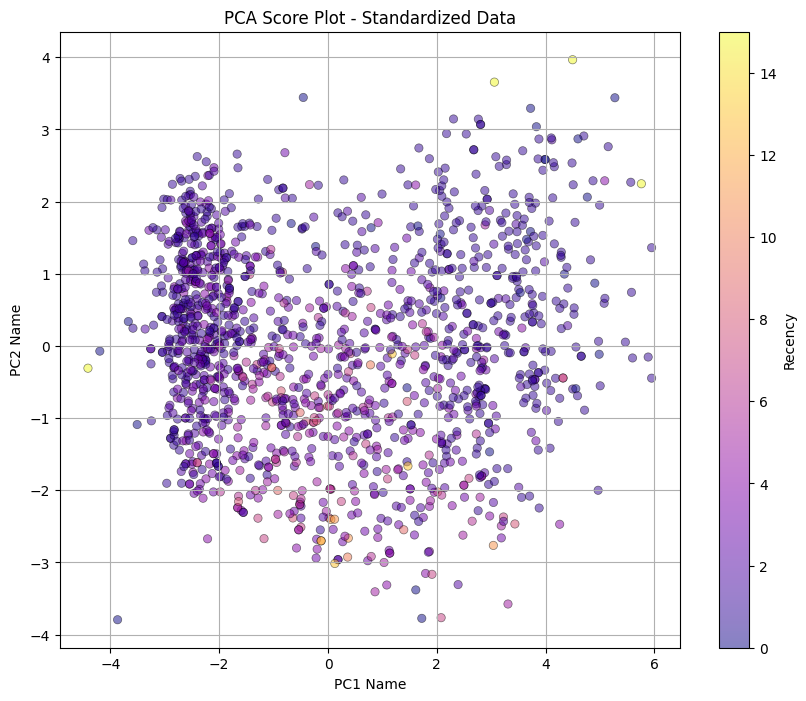

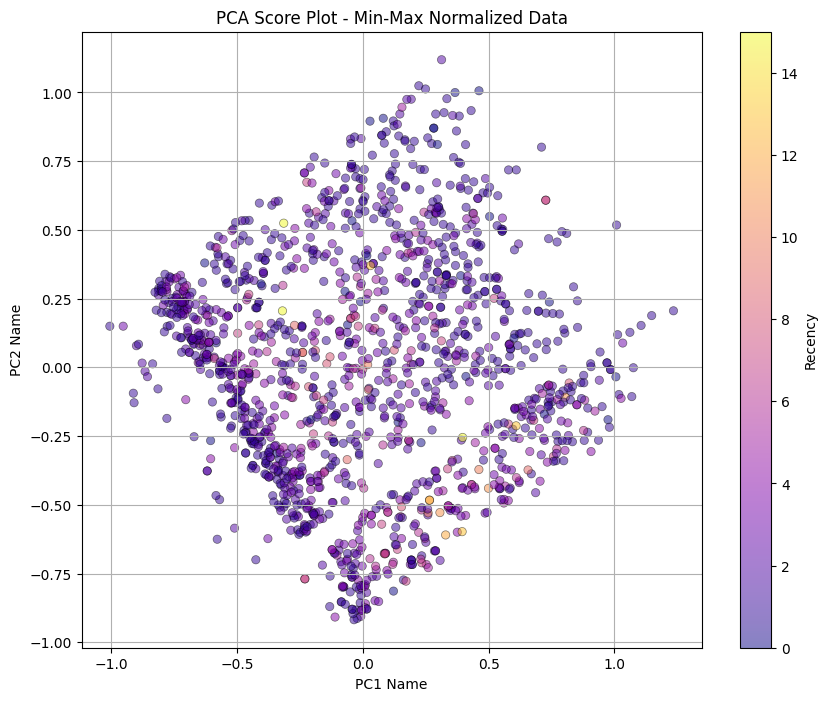

In [178]:
# TODO I added the label to make it colorful we have to choose the best label, we can also do it for different labels, also change the above caption
def plot_pca_scores(pca_scores, pc_names, labels, title):
    """
    Plot the PCA scores for the first two principal components.
    :param labels: the label for data coloring
    :param pca_scores: Array of PCA scores (transformed features)
    :param pc_names: List of names for the first two principal components
    :param title: Title for the plot
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_scores[:, 0], pca_scores[:, 1], alpha=0.5, c=labels, cmap='plasma', edgecolor='k',
                          linewidth=0.5)
    plt.xlabel(pc_names[0])
    plt.ylabel(pc_names[1])
    plt.title(title)
    plt.colorbar(scatter, label='Recency')
    plt.grid(True)
    plt.show()


plot_pca_scores(X_std_pca, ['PC1 Name', 'PC2 Name'], labels=workdf['NumDealsPurchases'],
                title='PCA Score Plot - Standardized Data')
plot_pca_scores(X_mm_pca, ['PC1 Name', 'PC2 Name'], labels=workdf['NumDealsPurchases'],
                title='PCA Score Plot - Min-Max Normalized Data')

# Exercise 5 (k-Means)
The term "with respect to the 'PC-space'" refers to performing in the space defined by the Principal Components (PCs) rather than in the original feature space. 

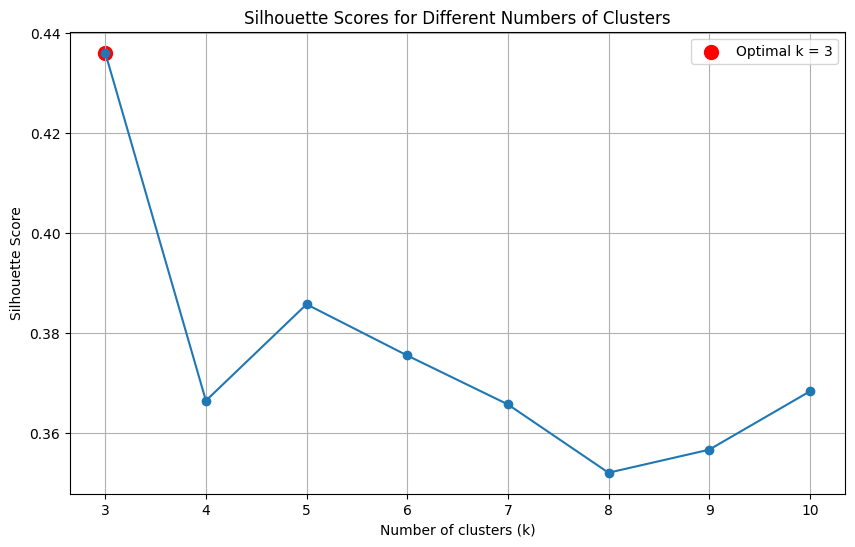

For Standardized Data optimal k is: 3 with Silhouette Score: 0.4360


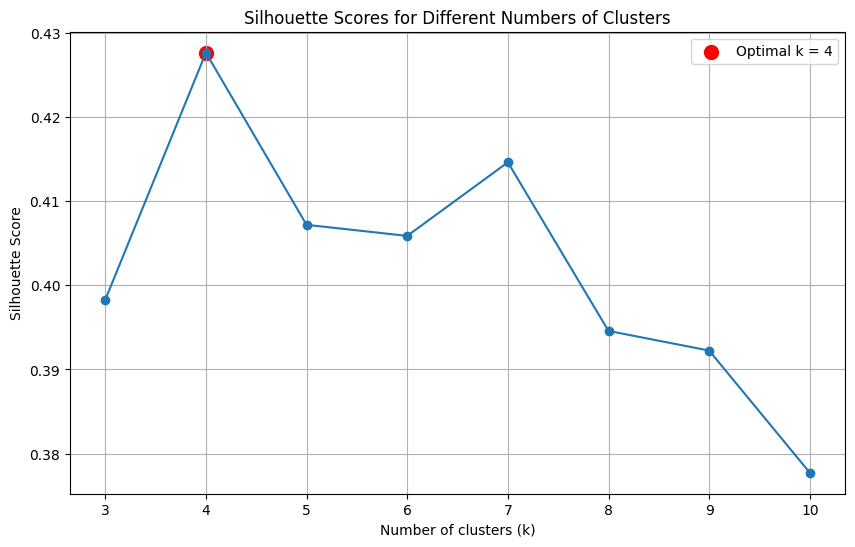

For Min-Max Normalized Data optimal k is: 4 with Silhouette Score: 0.4276


In [179]:
def optimal_k_using_silhouette(pca_data, k_range=range(3, 11)):
    """
    Find the optimal number of clusters (k) using the silhouette coefficient and plot the scores.
    :param pca_data: Data transformed into PCA space
    :param k_range: Range of k values to test
    :return: Optimal k value and silhouette score for optimal k
    """
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=rs, n_init=10)
        cluster_labels = kmeans.fit_predict(pca_data)
        silhouette_avg = silhouette_score(pca_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Determine the optimal number of clusters
    optimal_k = k_range[np.argmax(silhouette_scores)]
    optimal_score = max(silhouette_scores)

    # Plotting the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.scatter(optimal_k, optimal_score, color='red', s=100, label=f'Optimal k = {optimal_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_k, optimal_score


# Example usage with your PCA-transformed data
std_optimal_k, std_silhouette_score = optimal_k_using_silhouette(X_std_pca)
print(f"For Standardized Data optimal k is: {std_optimal_k} with Silhouette Score: {std_silhouette_score:.4f}")

mm_optimal_k, mm_silhouette_score = optimal_k_using_silhouette(X_mm_pca)
print(f"For Min-Max Normalized Data optimal k is: {mm_optimal_k} with Silhouette Score: {mm_silhouette_score:.4f}")



# Exercise 6 (Clusters and Centroid Interpretation and Visualization)

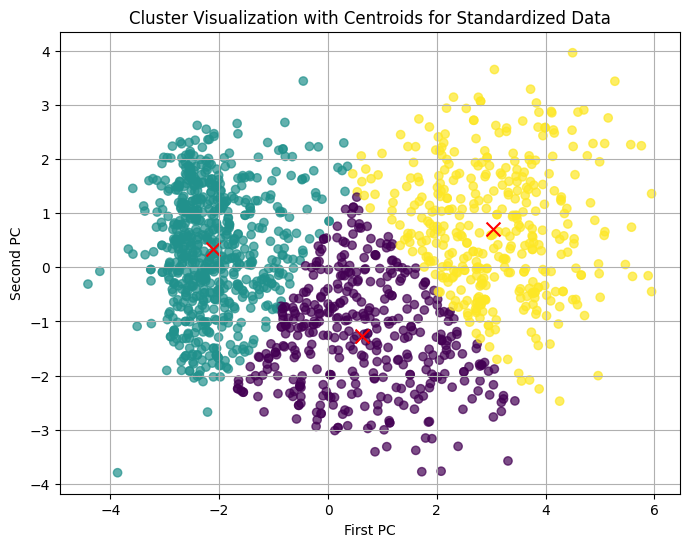

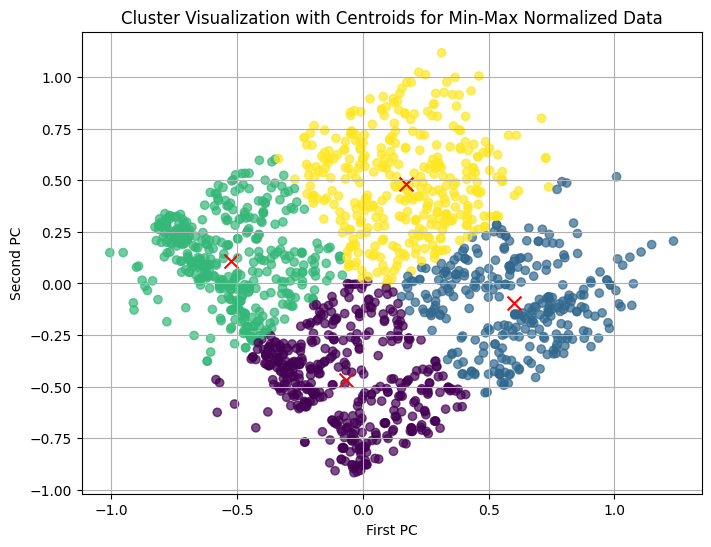

In [180]:
def plot_clusters_and_centroids(pca, kmeans, title):
    """
    Analyze and visualize the centroids of k-means clustering on PCA-transformed data, 
    with data points colored by cluster assignment.
    :param title: the name for the plot
    :param pca: PCA-transformed dataset
    :param kmeans: Trained kMeans object
    """
    # Visualize centroids and data points
    plt.figure(figsize=(8, 6))
    plt.scatter(pca[:, 0], pca[:, 1], alpha=0.7, c=kmeans.labels_, cmap='viridis')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='red')
    plt.xlabel('First PC')
    plt.ylabel('Second PC')
    plt.title('Cluster Visualization with Centroids for {}'.format(title))
    plt.grid()
    plt.show()


kmeans_std = KMeans(n_clusters=std_optimal_k, random_state=rs, n_init=10).fit(X_std_pca)

kmeans_mm = KMeans(n_clusters=mm_optimal_k, random_state=rs, n_init=10).fit(X_mm_pca)

plot_clusters_and_centroids(X_std_pca, kmeans_std, "Standardized Data")

plot_clusters_and_centroids(X_mm_pca, kmeans_mm, "Min-Max Normalized Data")


## Describing the Centroids

### Standardized Data Centroids

In [181]:
num_pcs = summary_table_std.shape[0]
num_centroids = len(kmeans_std.cluster_centers_)

for centroid_index in range(num_centroids):
    print(f"Centroid {centroid_index + 1}:")

    for pc_index in range(num_pcs):
        pc_coord = kmeans_std.cluster_centers_[centroid_index][pc_index]
        explained_variance = summary_table_std['Explained Variance'][pc_index]
        dominant_features = summary_table_std['Dominant Features'][pc_index]

        print(f"\tPC{pc_index + 1}({pc_coord:.4f})")
        print(f"\t\t Explained Variance: {explained_variance}")
        print(f"\t\t Dominant Features: {dominant_features}")


Centroid 1:
	PC1(0.6293)
		 Explained Variance: 32.19%
		 Dominant Features: ['NumCatalogPurchases (0.34)', 'MntMeatProducts (0.34)', 'NumStorePurchases (0.33)']
	PC2(-1.2601)
		 Explained Variance: 10.75%
		 Dominant Features: ['Dt_Customer_Year (0.59)', 'Dt_Customer_Month (-0.51)', 'NumWebVisitsMonth (-0.34)']
Centroid 2:
	PC1(-2.1083)
		 Explained Variance: 32.19%
		 Dominant Features: ['NumCatalogPurchases (0.34)', 'MntMeatProducts (0.34)', 'NumStorePurchases (0.33)']
	PC2(0.3378)
		 Explained Variance: 10.75%
		 Dominant Features: ['Dt_Customer_Year (0.59)', 'Dt_Customer_Month (-0.51)', 'NumWebVisitsMonth (-0.34)']
Centroid 3:
	PC1(3.0420)
		 Explained Variance: 32.19%
		 Dominant Features: ['NumCatalogPurchases (0.34)', 'MntMeatProducts (0.34)', 'NumStorePurchases (0.33)']
	PC2(0.7104)
		 Explained Variance: 10.75%
		 Dominant Features: ['Dt_Customer_Year (0.59)', 'Dt_Customer_Month (-0.51)', 'NumWebVisitsMonth (-0.34)']


#### Interpretation
- **Dominant Features in PC1:** 'NumCatalogPurchases', 'MntMeatProducts', 'NumStorePurchases' all moderately high.
- **Dominant Features in PC2:** 'Dt_Customer_Year', 'Dt_Customer_Month', 'NumWebVisitsMonth' (suggesting recent engagement and web activity).


##### Centroid 1: "Engaged Recent Web Visitors"
- **PC1 Coordinate (0.6293):** Positive, moderate value in PC1 suggests higher engagement in behaviors captured by PC1's dominant features.
- **PC2 Coordinate (-1.2601):** Strong negative value in PC2, which might indicate characteristics opposite to the positive aspects of PC2's dominant features.


##### Centroid 2: "Less Active, Moderately Recent Customers"
- **PC1 Coordinate (-2.1083):** Strong negative value in PC1 suggests low engagement in PC1's dominant features.
- **PC2 Coordinate (0.3378):** Slightly positive, indicating alignment with PC2's positive aspects but not strongly.


##### Centroid 3: "Highly Engaged, Established Customers"
- **PC1 Coordinate (3.0420):** Very high value in PC1, indicating strong engagement in PC1's dominant features.
- **PC2 Coordinate (0.7104):** Moderately high, aligning with the positive aspects of PC2's dominant features.


##### General Observations:
- **PC1 Dominant Features:** High values in PC1, which has a significant explained variance, suggest strong engagement in catalog purchases, meat products, and store purchases.
- **PC2 Dominant Features:** The interpretation is nuanced by PC2's smaller explained variance, but it seems to relate to customer's recentness and online engagement.

## Min-Max Normalized Data Centroids

In [182]:
num_pcs = summary_table_mm.shape[0]
num_centroids = len(kmeans_mm.cluster_centers_)

for centroid_index in range(num_centroids):
    print(f"Centroid {centroid_index + 1}:")

    for pc_index in range(num_pcs):
        pc_coord = kmeans_mm.cluster_centers_[centroid_index][pc_index]
        explained_variance = summary_table_mm['Explained Variance'][pc_index]
        dominant_features = summary_table_mm['Dominant Features'][pc_index]

        print(f"\tPC{pc_index + 1}({pc_coord:.4f})")
        print(f"\t\t Explained Variance: {explained_variance}")
        print(f"\t\t Dominant Features: {dominant_features}")


Centroid 1:
	PC1(-0.0678)
		 Explained Variance: 22.13%
		 Dominant Features: ['Dt_Customer_Year (-0.46)', 'NumStorePurchases (0.39)', 'Kidhome (-0.38)']
	PC2(-0.4695)
		 Explained Variance: 19.16%
		 Dominant Features: ['Dt_Customer_Year (0.59)', 'Dt_Customer_Month (-0.56)', 'Kidhome (-0.29)']
Centroid 2:
	PC1(0.6025)
		 Explained Variance: 22.13%
		 Dominant Features: ['Dt_Customer_Year (-0.46)', 'NumStorePurchases (0.39)', 'Kidhome (-0.38)']
	PC2(-0.0939)
		 Explained Variance: 19.16%
		 Dominant Features: ['Dt_Customer_Year (0.59)', 'Dt_Customer_Month (-0.56)', 'Kidhome (-0.29)']
Centroid 3:
	PC1(-0.5226)
		 Explained Variance: 22.13%
		 Dominant Features: ['Dt_Customer_Year (-0.46)', 'NumStorePurchases (0.39)', 'Kidhome (-0.38)']
	PC2(0.1078)
		 Explained Variance: 19.16%
		 Dominant Features: ['Dt_Customer_Year (0.59)', 'Dt_Customer_Month (-0.56)', 'Kidhome (-0.29)']
Centroid 4:
	PC1(0.1698)
		 Explained Variance: 22.13%
		 Dominant Features: ['Dt_Customer_Year (-0.46)', 'NumStor


#### Interpretation:

##### Centroid 1: "Recent, Family-Oriented Shoppers"
- **PC1 (-0.0678):** Slightly negative, indicating a trend away from characteristics like an earlier customer year and fewer store purchases.
- **PC2 (-0.4695):** Strongly negative, suggesting a recent join year and potentially less engagement (negative value for 'Dt_Customer_Month').

##### Centroid 2: "Moderate, Newly Engaged Customers"
- **PC1 (0.6025):** Positive, indicating alignment with features like earlier customer year and higher store purchases.
- **PC2 (-0.0939):** Slightly negative, pointing towards a more recent customer join date.

##### Centroid 3: "New, Less Active Family Shoppers"
- **PC1 (-0.5226):** Strongly negative, suggesting newer customers with fewer store purchases.
- **PC2 (0.1078):** Slightly positive, indicating a bit older customer join year but still aligning slightly with negative aspects of PC2.

##### Centroid 4: "Established, Regular Buyers"
- **PC1 (0.1698):** Slightly positive, suggesting customers with slightly earlier join years and moderate store purchases.
- **PC2 (0.4808):** Positive, indicating more established customers with fewer recent web visits.

##### Interpretation Logic:
- **Positive PC1 Values:** Indicate alignment with dominant features like earlier customer year and higher store purchases.
- **Negative PC1 Values:** Suggest newer customers or those with lower engagement in store purchases.
- **Positive PC2 Values:** Point towards more established customer relationships.
- **Negative PC2 Values:** Indicate newer customer relationships or less engagement in certain activities like web visits.



# Exercise 7 (Clusters and Centroids Evaluation)

## Internal Evaluation - Silhouette Scores

In [183]:
silhouette_std = silhouette_score(X_std_pca, kmeans_std.labels_)
silhouette_mm = silhouette_score(X_mm_pca, kmeans_mm.labels_)

print(f"Silhouette Score for Standardized Data: {silhouette_std:.4f}")
print(f"Silhouette Score for Min-Max Normalized Data: {silhouette_mm:.4f}")


Silhouette Score for Standardized Data: 0.4360
Silhouette Score for Min-Max Normalized Data: 0.4276


Checking the distribution of labels in dataset:

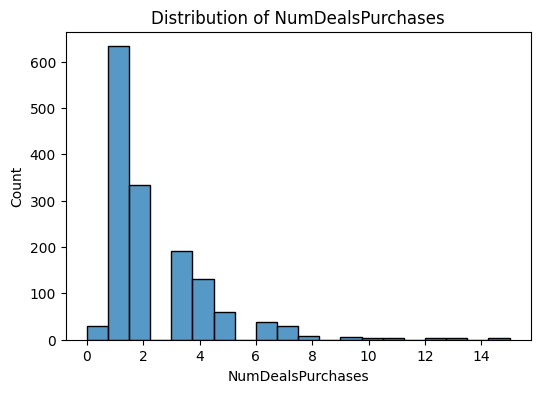

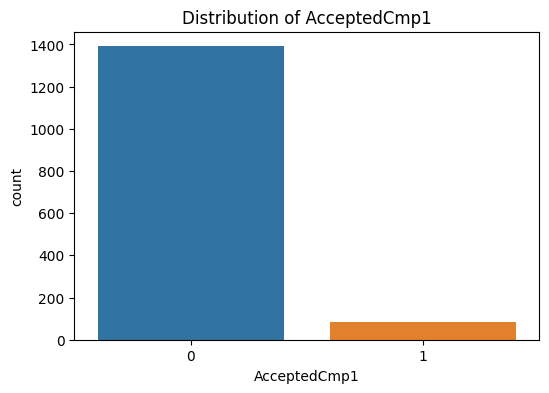

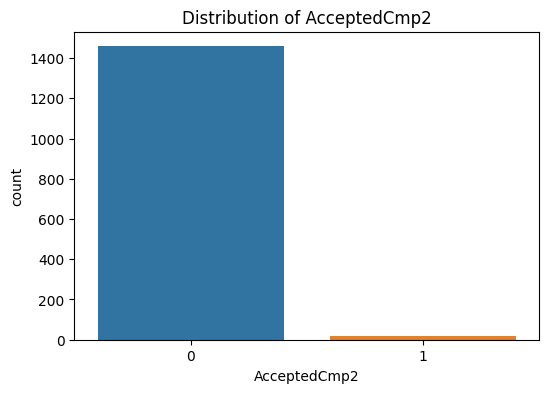

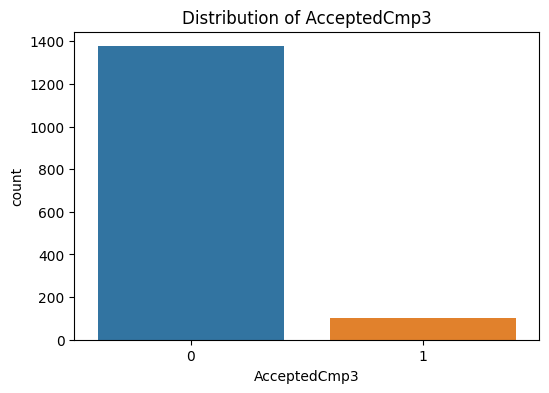

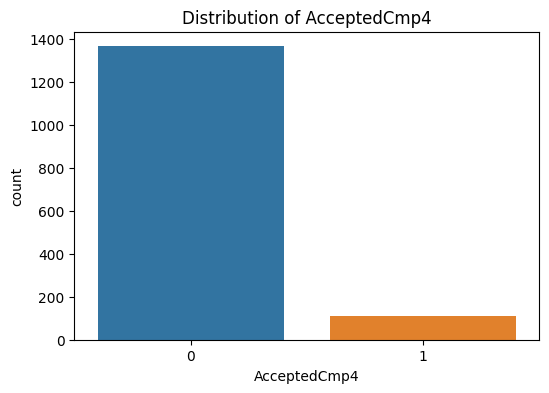

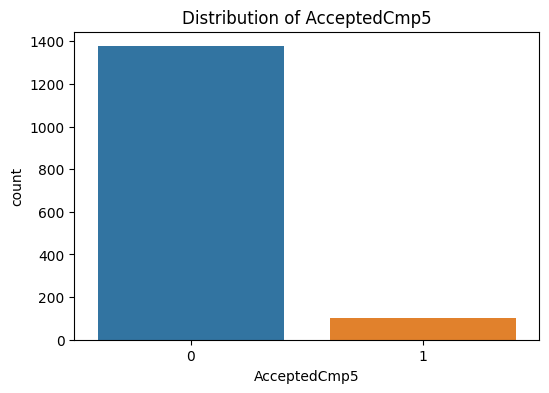

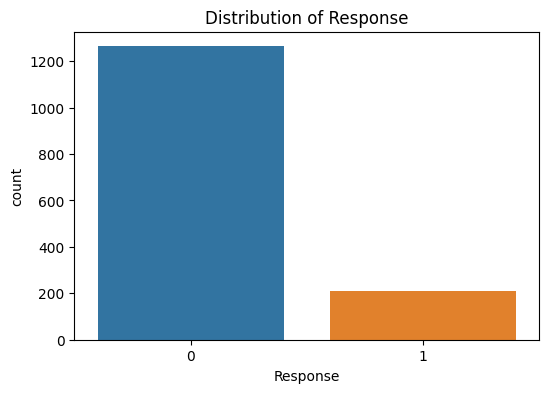

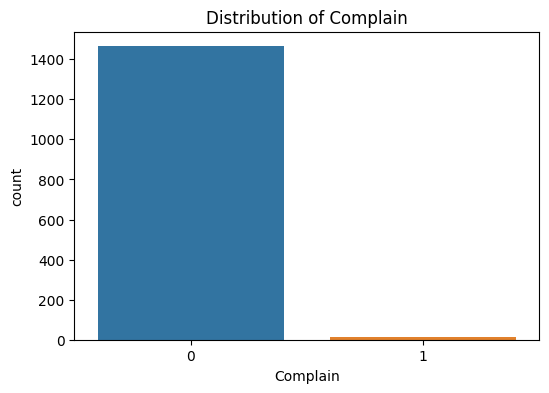

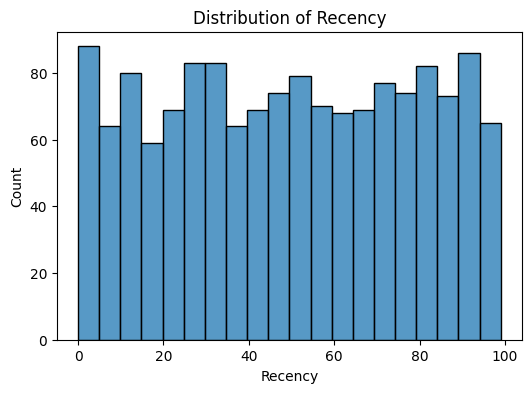

In [186]:
for label in labels:
    plt.figure(figsize=(6, 4))
    if workdf[label].nunique() <= 2:  # For binary labels
        sns.countplot(x=label, data=workdf)
    else:  # For continuous labels
        sns.histplot(workdf[label], bins=20, kde=False)
    plt.title(f'Distribution of {label}')
    plt.show()

Among the shown histograms for each label, the distribution of the 'Recency' label appears to be quite uniform, suggesting that customers' last purchase is fairly evenly spread out over the time frame considered. It can be a meaningful label for external evaluation for several reasons:
- ** Customer Engagement: 'Recency' can indicate how recently customers have engaged with the company, which is a key metric in customer relationship management. Recent interactions might suggest more active or engaged customers.

- ** Segmentation Relevance: Clusters may differentiate between recent and less recent customers. This can be valuable for targeted marketing campaigns.

- ** Behavioral Insight: The behavior of customers with different 'Recency' values within the same cluster may offer insights into the cluster's characteristics.

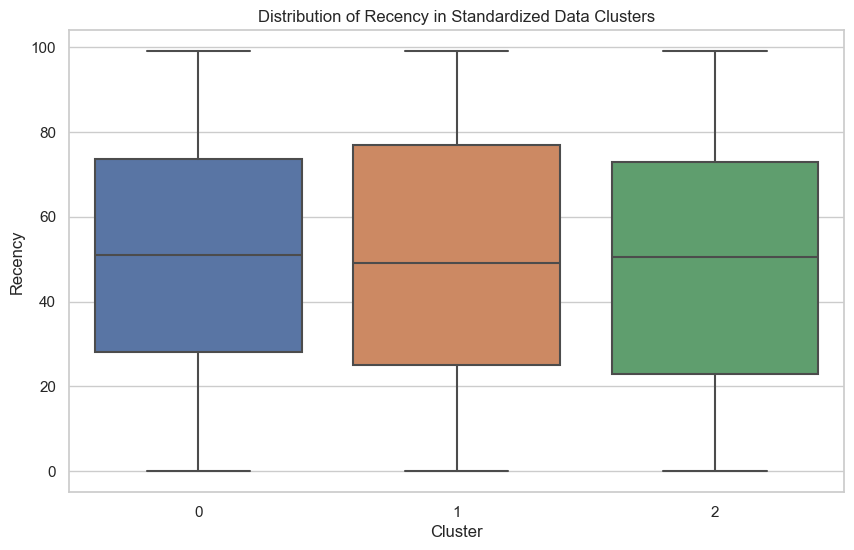

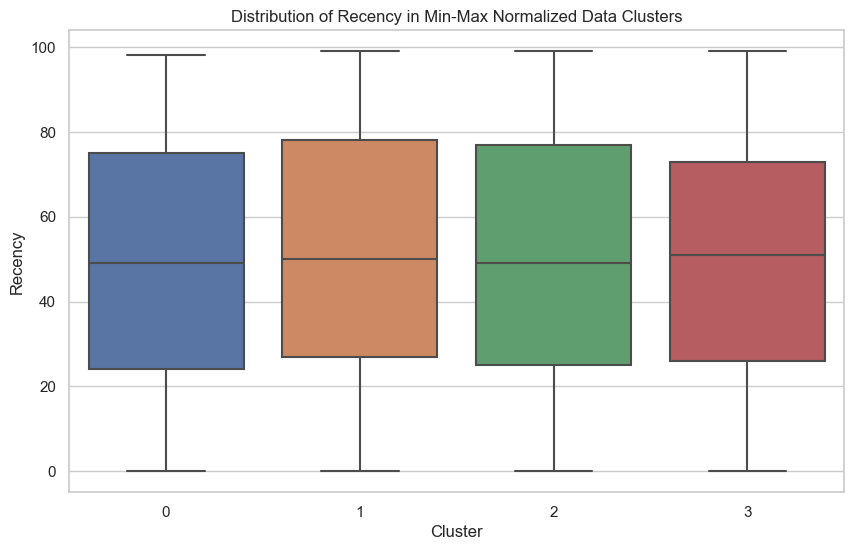

In [195]:
def plot_external_label_distribution(original_df, kmeans_model, label_column, title=''):
    """
    Plot the distribution of a specified label within each cluster.
    :param original_df: Original DataFrame with label_column
    :param kmeans_model: Trained KMeans model
    :param label_column: The name of the column to use for external evaluation
    """
    # Add the cluster assignments to the original DataFrame
    df_with_clusters = original_df.copy()
    df_with_clusters['Cluster'] = kmeans_model.labels_

    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=label_column, data=df_with_clusters)
    plt.title(f"Distribution of {label_column} in {title} Clusters")
    plt.xlabel('Cluster')
    plt.ylabel(label_column)
    plt.show()


plot_external_label_distribution(original_df=workdf, kmeans_model=kmeans_std, label_column='Recency',
                                 title="Standardized Data")
plot_external_label_distribution(original_df=workdf, kmeans_model=kmeans_mm, label_column='Recency',
                                 title="Min-Max Normalized Data")


In [196]:
# TODO: Compare the results obtained from Xworkdf_std and Xworkdf_mm and comment them